<a id="back_to_top"></a>

<span style="text-decoration:underline">

## Table of contents
</span>

This notebook has the following sections:
1. [Import Packages](#import_packages)
2. [Create DataFrames For Each Yelp Dataset](#create_dataframes)
3. [The Big Question](#Code_To_Adjust)
  - [Part 1: Number of Attributes Posted](#part_1)
  - [Part 2: Number of Yelp Reviews](#part_2)
  - [Part 3: Yelp Business Rating](#part_3)
  - [Part 4: Quality of Posted Photos](#part_4)

<span style="text-decoration:underline">

# Statistical Data Analysis:
</span>

- **Think of the following questions and apply them to your dataset:**
  - **Are there variables that are particularly significant in terms of explaining the answer to your project question?**
    - The following variables may be of interest to look into:
      - Number of attributes posted on yelp for businesses
      - Number of Yelp reviews that businesses received
      - Yelp rating of businesses
      - Quality of photos posted for a business
  - **Are there significant differences between subgroups in your data that may be relevant to your project aim?**
    - Two particular subgroups may be of interest to look into:
      - Businesses that were positively rated by a user (User rating is 1 star or more than the business' Yelp rating)
      - Businesses that were negatively rated by a user (User rating is less than 1 star or lesser than the business' Yelp rating)
  - **Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?**
    - See the following parts for analysis of correlations between variables:
      - [Part 1: Number of Attributes Posted](#part_1)
      - [Part 2: Number of Yelp Reviews](#part_2)
      - [Part 3: Yelp Business Rating](#part_3)
      - [Part 4: Quality of Posted Photos](#part_4)
  - **What are the most appropriate tests to use to analyze these relationships?**
    - The most appropriate test to use to analyze these relationships is the T-test for the means of two independent samples of scores. There is a lot of information provided in the Yelp datasets to determine some oft he statistical properties with much certainty like the mean and standard deviation.

<a id="import_packages"></a>

[Back To Top](#back_to_top)
<div class="alert alert-block alert-danger">

## Import necessary packages
</div>

In [1]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import string

# Import file reading packages
import json
import ast

from itertools import chain, starmap
import nltk
from nltk.corpus import stopwords

# Import Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import folium
from folium import plugins

import collections
import pickle 

import scipy.stats
import scipy.signal as signal
import scipy.ndimage.filters as filters
import scipy.special as special
import scipy.optimize as optimize

import skimage.io
import skimage.transform

import cv2

import sys

sys.path.append('/Users/jeromegonzaga/.local/lib/python3.7/site-packages')

from libsvm import svmutil

<div class="alert alert-block alert-danger">

## Methods to be used in analysis
</div>

In [2]:
def flatten_json_iterative_solution(dictionary):
    """Flatten a nested json file"""

    def unpack(parent_key, parent_value):
        """Unpack one level of nesting in json file"""
        # Unpack one level only!!!
        
        if isinstance(parent_value, dict):
            for key, value in parent_value.items():
                temp1 = parent_key + '_' + key
                yield temp1, value
        elif isinstance(parent_value, list):
            i = 0 
            for value in parent_value:
                temp2 = parent_key + '_'+str(i) 
                i += 1
                yield temp2, value
        else:
            yield parent_key, parent_value    

            
    # Keep iterating until the termination condition is satisfied
    while True:
        # Keep unpacking the json file until all values are atomic elements (not dictionary or list)
        dictionary = dict(chain.from_iterable(starmap(unpack, dictionary.items())))
        # Terminate condition: not any value in the json file is dictionary or list
        if not any(isinstance(value, dict) for value in dictionary.values()) and \
           not any(isinstance(value, list) for value in dictionary.values()):
            break

    return dictionary

In [3]:
# method to change string to another datatype, if necessary and if possible

def str_to_other(string):

    # Return a dictionary or list if string looks like a dictionary or list
    try:
        if isinstance(string, dict):
            dictionary = string
            return dictionary
        else:
            try:
                dictionary = ast.literal_eval(string)
                return dictionary
            except:
                pass
    except:
        pass

    # Return an integer if string looks like an integer
    try:
        integer = int(string)
        return integer
    except:
        pass

    # Return a float if string looks like a float
    try:
        number = float(string)
        return number

    # Return a bool if string looks like a bool
    except:
        if string =='True' or string == 'true':
            return True
        elif string == 'False' or string == 'false':
            return False
        elif isinstance(string, bool):
            return string

    # If none of the above, return original string
        else:
            return string

In [4]:
# Method to extract the column names of 

def columns_from_nested_dict(df_dict):

    set_keys = []
    temp_dict = str_to_other(df_dict)

    for key in temp_dict:
        value = str_to_other(temp_dict[key])
        if isinstance(value, dict):
            set_keys.append(key)
            sub_keys = list(columns_from_nested_dict(value))
            set_keys.append(sub_keys)
        else:
            pass
        set_keys.append(key)
    
    return set_keys

In [5]:
# Method to extract the keys and values of dict
def unpack_dict(df_dict):

    set_keys = []
    set_values = []
    temp_dict = str_to_other(df_dict)
#     print(df_dict)
#     print(temp_dict)
#     if temp_dict == np.nan:
#         pass
#     else:
    for key in temp_dict:
        if isinstance(temp_dict[key], bool):
            value = temp_dict[key]
        else:
            value = str_to_other(temp_dict[key])

        if isinstance(value, dict):
            unpack_dict(value)
        else:
            pass
        set_keys.append(key)
        set_values.append(value)
    
    return [set_keys, set_values]

In [6]:
## Method to determine count of positive and negative words used in the tips DataFrame per year, per month

def countSentimentPerMonth(positive_words, negative_words):

    positives = '|'.join(positive_words)

    negatives = '|'.join(negative_words)

    search_df = df_tip_subset.reset_index()

    search_df['year_month'] = search_df['datetime'].dt.strftime('%Y%m')

    positive_tip_count = search_df[search_df['text'].str.contains((positives).lower())]\
    .groupby(['year_month']).count().compliment_count

    negative_tip_count = search_df[search_df['text'].str.contains((negatives).lower())]\
    .groupby(['year_month']).count().compliment_count
    
    return [positive_tip_count, negative_tip_count]

In [7]:
## Method to determine count of positive and negative words used in the tips DataFrame per year, per month

def countSentimentPerBusiness(positive_words, negative_words):

    positives = '|'.join(positive_words)

    negatives = '|'.join(negative_words)

    search_df = df_tip_subset.reset_index()

    positive_tip_count = search_df[search_df['text'].str.contains((positives).lower())]\
    .groupby(['business_id']).count().compliment_count.sort_values(ascending = False)

    negative_tip_count = search_df[search_df['text'].str.contains((negatives).lower())]\
    .groupby(['business_id']).count().compliment_count.sort_values(ascending = False)
    
    return [positive_tip_count, negative_tip_count]

In [8]:
### Method to create the x and y arrays for a CDF plot

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [9]:
### Methods used to provide a quality score for photos

def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')

def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))

def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))
    
    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    
    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
    
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)
    
    return alpha, mean, sigma_l, sigma_r

def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    def calculate_features(coefficients_name, coefficients, accum=np.array([])):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var]
        
        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
    
    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)
    
    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
    flatten_features = list(chain.from_iterable(features))
    return np.array(flatten_features)

def load_image(url):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, plugin='pil')

def plot_histogram(x, label):
    n, bins = np.histogram(x.ravel(), bins=50)
    n = n / np.max(n)
    plt.plot(bins[:-1], n, label=label, marker='o')
    
def scale_features(features):
    file_open = '/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/normalize.pickle'
    with open(file_open, 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model\
        ('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/brisque_svm.txt')
    scaled_brisque_features = scale_features(brisque_features)
    
    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    
    nr_classifier = 1
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)

<a id="create_dataframes"></a>

[Back To Top](#back_to_top)

## Create pandas DataFrames from each of the Yelp datasets

In [10]:
csv_filepath = '/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_dataset/'
csv_files = {'business':'business.csv', 'checkin':'checkin.csv', 'photo':'photo.csv',\
             'review':'review.csv', 'tip':'tip.csv', 'user':'user.csv'}

In [11]:
%%time
df_business = pd.read_csv(csv_filepath + csv_files['business'])
df_photo = pd.read_csv(csv_filepath + csv_files['photo'], lineterminator='\n')
df_review = pd.read_csv(csv_filepath + csv_files['review'])
df_tip = pd.read_csv(csv_filepath + csv_files['tip'])
df_user = pd.read_csv(csv_filepath + csv_files['user'], dtype = {'elite': str })
df_checkin = pd.read_csv(csv_filepath + csv_files['checkin'])

<string>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 13s, sys: 13.1 s, total: 1min 26s
Wall time: 1min 26s


In [12]:
# Drop rows where the 'hours' is blank, blank 'hours' most likely means the business closed down
df_business = df_business[df_business['hours'].notnull()]

In [13]:
# DataFrame of businesses and attributes
df_business = df_business.fillna('')
df_business = df_business.\
    drop(df_business.columns[df_business.columns.str.contains('Unnamed')], 1)
df_business = df_business.reset_index().drop('index', axis=1)

### Adjusting date format for some datasets

In [14]:
time_format = '%Y-%m-%d %H:%M'
df_review['datetime'] = pd.to_datetime(df_review['date'], format = time_format)

### Columns available to analyze

In [15]:
df_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [16]:
df_photo.columns

Index(['Unnamed: 0', 'caption', 'photo_id', 'business_id', 'label'], dtype='object')

In [17]:
df_review.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date', 'datetime'],
      dtype='object')

In [18]:
df_tip.columns

Index(['Unnamed: 0', 'user_id', 'business_id', 'text', 'date',
       'compliment_count'],
      dtype='object')

In [19]:
df_review.shape

(6685902, 11)

In [20]:
df_tip.shape

(1223094, 6)

In [21]:
df_checkin.columns

Index(['Unnamed: 0', 'business_id', 'date'], dtype='object')

In [22]:
df_user.columns

Index(['Unnamed: 0', 'user_id', 'name', 'review_count', 'yelping_since',
       'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos'],
      dtype='object')

### Add number of check-ins to Check-In DataFrame

In [23]:
%%time
df_checkin['num_checkin'] = 0
for x in range(df_checkin.shape[0]):
    checkin_text = df_checkin['date'].iloc[x]
    checkin_count = len(checkin_text.split(','))
    df_checkin['num_checkin'].iloc[x] = checkin_count

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


CPU times: user 10min 3s, sys: 2.47 s, total: 10min 5s
Wall time: 10min 7s


## Analysis of the following datasets to see if there are any patterns:
- df_business
- df_user
- df_review

### Getting the list of users with the most amount of reviews in the Yelp dataset

In [24]:
user_review_count = pd.DataFrame(df_review.user_id.value_counts()).reset_index()

In [25]:
user_review_count.rename(columns = {'user_id':'review_count', 'index':'user'}, inplace = True)

In [26]:
df_user_review_count = df_user.join(user_review_count.set_index('user'), on='user_id', how='inner', \
                                    lsuffix = '_user', rsuffix = '_review')

In [27]:
df_user_review_count = df_user_review_count[['user_id', 'name', 'review_count_user', 'friends',\
                           'review_count_review']].sort_values(by = 'review_count_review', ascending = False)\
                           .reset_index().drop('index', axis = 1)

df_user_review_count.head(50)

,user_id,name,review_count_user,friends,review_count_review
0,CxDOIDnH8gp9KXzpBHJYXw,Jennifer,6314,"mrru6hbeQLvagU4vkfuqmw, wt0lL3xJIGeJ1r0qO-vkrg...",4129
1,bLbSNkLggFnqwNNzzq-Ijw,Stefany,4321,"8mS7JcGREFgzGzI5qj0b2A, Tix0G3J3uet0PU-GezBooA...",2354
2,PKEzKWv_FktMm2mGPjwd0Q,Norm,2421,"9h3GjDZbkD0pQsx-e-gr0A, 6iNeElU0lFkKdBu3wAzEBw...",1822
3,ELcQDlf69kb-ihJfxZyL0A,Brad,1642,"MM4RJAeH6yuaN8oZDSt0RA, HP_UkrcE_ILzQ-BB_R-cEA...",1764
4,DK57YibC5ShBmqQl97CKog,Karen,2340,"_tDb7UEeJS623b8RTjSIvg, v0JtfrbTDNPvSp3rXv8IRg...",1727
5,U4INQZOPSUaj8hMjLlZ3KA,Michael,4308,"yqumc_CYlWeghZ5vM3Ilyw, mX84lBw8jwS2uQqdgKu_aA...",1559
6,QJI9OSEn6ujRCtrX06vs1w,J,1982,"SDytcPY5fiuuDbTkPE8GyA, Pn4W0F3wc6B5fAEwpKY0rQ...",1496
7,d_TBs6J3twMy9GChqUEXkg,Jennifer,1929,"fBf46-ffTlLIm_WQFvZ6AQ, o9DYSlFm9pQwiurVs8U5ig...",1360
8,hWDybu_KvYLSdEFzGrniTw,Bruce,10022,"QZ3grLRAy7do7inT4OcltQ, 6pbATMd0sGeOJvAEt6znqw...",1355
9,cMEtAiW60I5wE_vLfTxoJQ,Jennifer,4190,"Ulwuycph-dbbO7YCicVjLA, 1L-9_upWG4AXEQt33xEiFQ...",1255


## Plot of categories and top words used in tips

In [28]:
categories_dict = {}
for row in range(df_business.shape[0]):
    categories_row = df_business.categories[row]
    categories_list = categories_row.strip('][').split(', ')
    
    for item in categories_list:
        if item in categories_dict.keys():
            categories_dict[item] += 1
        else:
            categories_dict[item] = 1

df_categories = pd.DataFrame(list(categories_dict.items()),
                             index = range(len(list(categories_dict.items()))))
df_categories.columns = ['category', 'count']

In [29]:
df_categories_subset = df_categories.sort_values(by = 'count', ascending = False).set_index('category').head(50)

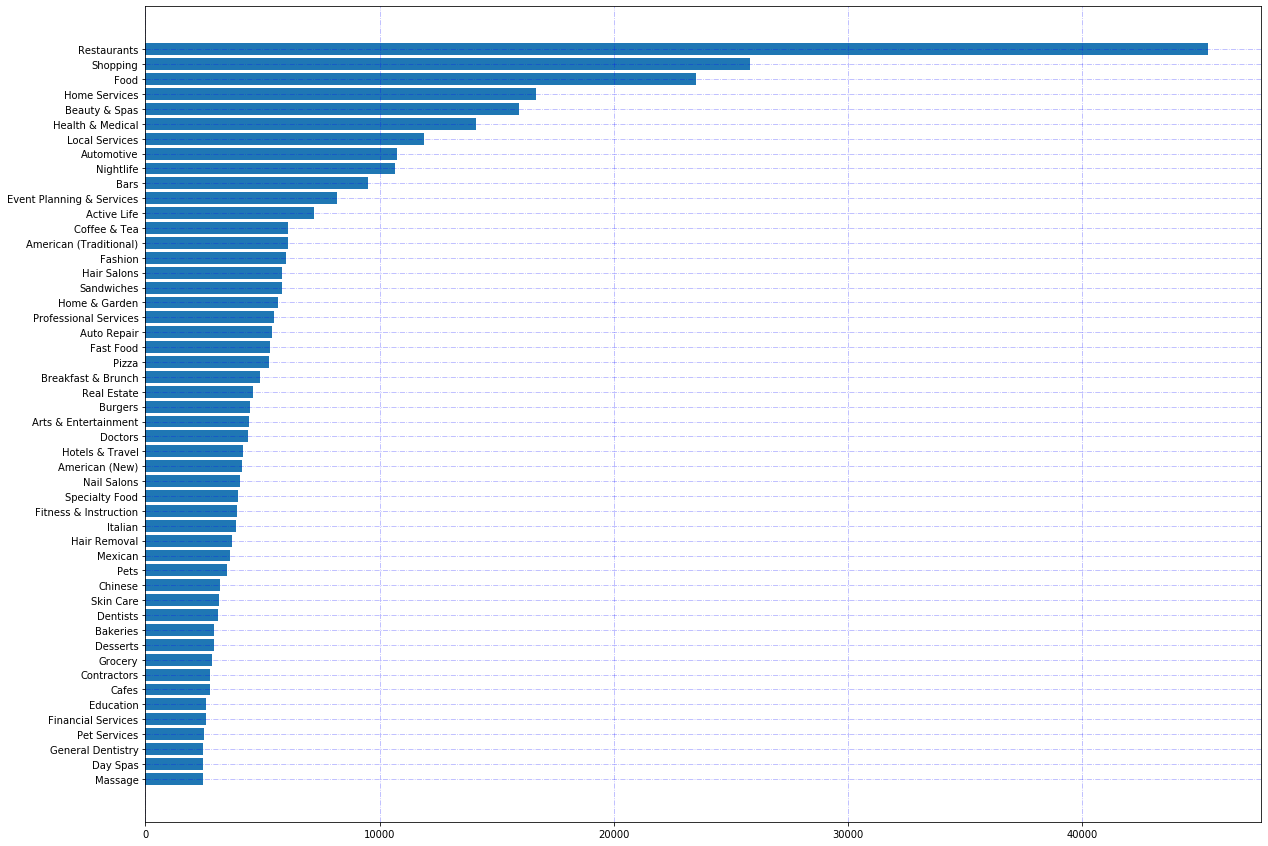

In [30]:
top_categories = list(df_categories_subset.index)
width = list(df_categories_subset['count'])

_ = plt.figure(figsize = (20,15))
_ = plt.barh(y = top_categories[::-1], width = width[::-1])
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.show()

In [31]:
pd.DataFrame(top_categories, columns = ['category']).head(15)

,category
0,Restaurants
1,Shopping
2,Food
3,Home Services
4,Beauty & Spas
5,Health & Medical
6,Local Services
7,Automotive
8,Nightlife
9,Bars


<a id="Code_To_Adjust"></a>
<a id="category_user"></a>

[Back To Top](#back_to_top)

<div class="alert alert-block alert-info">
<b>Note:</b> Start of code to adjust per category and per user
    
# Start adjusting code here!

</div>

<span style="text-decoration:underline">

# The Big Question!
</span>

A Yelper will typically decide on whether to go to a specific business based on the information of the business posted on Yelp - whether it is the business' Yelp rating, reviews from other Yelpers, the number of attributes, or even based on the photos. However, how much does this information really affect whether or not a Yelper likes the business? How much does a Yelper's rating of a business get affected by whether a business provides information on attributes, pictures, or even the number of tips or reviews? Let's find out!

**Is there any relationship between the number of reviews, attributes, check-ins, tips, Yelp rating or quality of business pictures and whether a user up-rates or down-rates a business? If a business has similar characteristics to that of the business that the Yelper up-rated, is it more likely that a Yelper will go to that similar business?**

(Note: An up-rating is when the user rates the business higher than the posted Yelp rating. A down-rating is when the user rates the business lower than the posted Yelp rating.)

## Subset the business dataset to only a specific category

### Assumptions made in this analysis:
- The number reviews posted by user is the number of visits made to businesses

In [32]:
# Query the reviews to only select indicated user

user_number = 0 # change this number to see results for other users
user_id = df_user_review_count['user_id'][user_number]
category = top_categories[0] # change this number to see results for other categories

# Query the businesses that match the indicated category

df_business_category = df_business[df_business['categories'].str.lower().str.contains(category.lower())]
user = df_review[df_review['user_id']==user_id]

In [33]:
user_business_category = user.join(df_business_category.set_index('business_id'), on='business_id', \
                            how = 'inner', lsuffix = '', rsuffix = '_business')\
                            .reset_index().drop(['index','Unnamed: 0'], axis = 1)

In [34]:
num_businesses = user_business_category.shape[0]
print(f'There are a total of {num_businesses} businesses for this user that match the "{category}" category.')
user_business_category.head()

There are a total of 2056 businesses for this user that match the "Restaurants" category.


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,datetime,...,state,postal_code,latitude,longitude,stars_business,review_count,is_open,attributes,categories,hours
0,9BJj4e1wCfkbK11mgSi4jA,CxDOIDnH8gp9KXzpBHJYXw,TvHC_I01Ilvd5_fFi4sqIg,3.0,3.0,0.0,0.0,Huge Buns! Good Quality!\n\nBrothers Bakery ha...,2014-01-17 00:53:31,2014-01-17 00:53:31,...,ON,L3R 0N8,43.825352,-79.307435,3.5,17,1,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...","Restaurants, Chinese, Food, Bakeries, Custom C...","{'Monday': '9:0-18:30', 'Tuesday': '7:0-19:0',..."
1,x1pG83XFBdcBk8ar36D-hQ,CxDOIDnH8gp9KXzpBHJYXw,lkM72Y21bjBqUGaW7iL7tQ,3.0,1.0,2.0,1.0,This review updated is based on dim sum experi...,2010-10-05 23:14:20,2010-10-05 23:14:20,...,ON,M1V 1V3,43.803568,-79.293509,3.0,83,1,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...","Seafood, Dim Sum, Chinese, Restaurants","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
2,47povAMFrG2bC1U8IG05nQ,CxDOIDnH8gp9KXzpBHJYXw,lkM72Y21bjBqUGaW7iL7tQ,2.0,2.0,2.0,1.0,I am going to rate Very Fair Seafood Restauran...,2010-01-25 04:08:47,2010-01-25 04:08:47,...,ON,M1V 1V3,43.803568,-79.293509,3.0,83,1,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...","Seafood, Dim Sum, Chinese, Restaurants","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
3,0a8PJ3SYCBmnu6-EzHFmFw,CxDOIDnH8gp9KXzpBHJYXw,gkxmQi2cipbysXFgT_w_jA,4.0,1.0,0.0,0.0,St Viateur Bagel & Cafe is my Bagel stop # 2.\...,2012-03-01 04:10:45,2012-03-01 04:10:45,...,QC,H2J 1X9,45.528427,-73.579110,4.0,320,1,"{'NoiseLevel': ""u'average'"", 'RestaurantsTable...","Cafes, Breakfast & Brunch, Bagels, Restaurants...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
4,4oUowhU3O4lodUXsq6wX0A,CxDOIDnH8gp9KXzpBHJYXw,O-uIEuv7JLUHajkemx_sVw,4.0,5.0,4.0,5.0,After going to Bier Mart for brunch without do...,2011-07-28 23:25:02,2011-07-28 23:25:02,...,ON,M5C 1C4,43.649817,-79.377147,4.0,596,1,"{'RestaurantsReservations': 'True', 'Restauran...","Restaurants, Bistros, Bars, Beer Bar, Pubs, Ni...","{'Monday': '11:30-1:0', 'Tuesday': '11:30-1:0'..."


[Back To The Big Question](#category_user)

[Back To Top](#back_to_top)

<div class="alert alert-block alert-danger">

## USER-SPECIFIC TOP CATEGORIES
</div>

## Get User's Top Categories

In [35]:
categories_dict_user = {}
for row in range(user_business_category.shape[0]):
    categories_row = user_business_category.categories[row]
    categories_list = categories_row.strip('][').split(', ')
    
    for item in categories_list:
        if item in categories_dict_user.keys():
            categories_dict_user[item] += 1
        else:
            categories_dict_user[item] = 1

df_categories_user = pd.DataFrame(list(categories_dict_user.items()),
                             index = range(len(list(categories_dict_user.items()))))
df_categories_user.columns = ['category', 'count']

In [36]:
df_categories_user_subset = df_categories_user.sort_values(by = 'count', ascending = False).set_index('category').head(50)

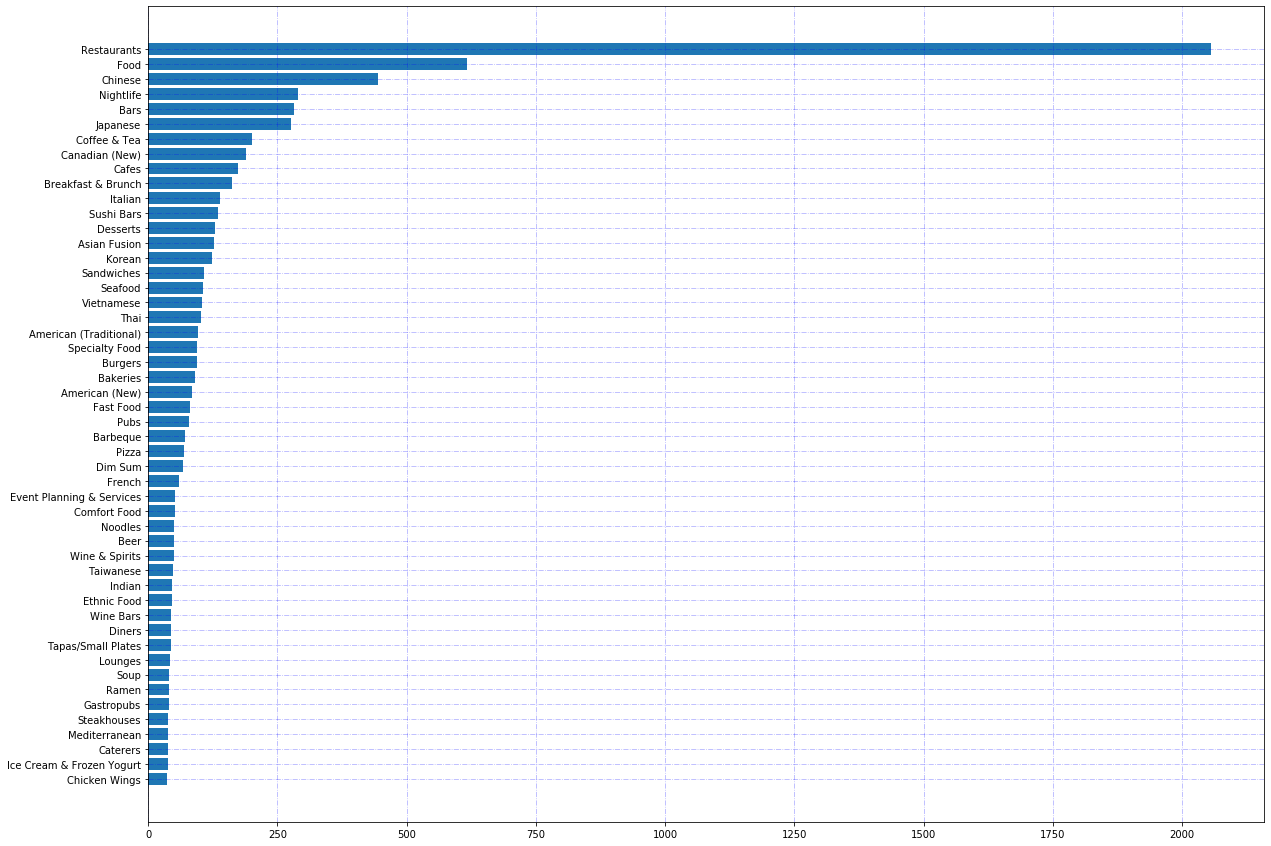

In [37]:
top_user_categories = list(df_categories_user_subset.index)
width = list(df_categories_user_subset['count'])

_ = plt.figure(figsize = (20,15))
_ = plt.barh(y = top_user_categories[::-1], width = width[::-1])
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.show()

In [38]:
pd.DataFrame(top_user_categories, columns = ['category']).head(15)

,category
0,Restaurants
1,Food
2,Chinese
3,Nightlife
4,Bars
5,Japanese
6,Coffee & Tea
7,Canadian (New)
8,Cafes
9,Breakfast & Brunch


In [39]:
# Query the reviews to only select indicated user

user_id = df_user_review_count['user_id'][user_number]
category = top_user_categories[2] # Change this number to see different user_specific categories

# Query the businesses that match the indicated category

df_business_category = df_business[df_business['categories'].str.lower().str.contains(category.lower())]

In [40]:
user_business_category = user.join(df_business_category.set_index('business_id'), on='business_id', \
                            how = 'inner', lsuffix = '', rsuffix = '_business')\
                            .reset_index().drop(['index'], axis = 1)

In [41]:
num_businesses = user_business_category.shape[0]
print(f'There are a total of {num_businesses} businesses for this user that match the "{category}" category.')
user_business_category.head()

There are a total of 444 businesses for this user that match the "Chinese" category.


,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,...,state,postal_code,latitude,longitude,stars_business,review_count,is_open,attributes,categories,hours
0,2233,9BJj4e1wCfkbK11mgSi4jA,CxDOIDnH8gp9KXzpBHJYXw,TvHC_I01Ilvd5_fFi4sqIg,3.0,3.0,0.0,0.0,Huge Buns! Good Quality!\n\nBrothers Bakery ha...,2014-01-17 00:53:31,...,ON,L3R 0N8,43.825352,-79.307435,3.5,17,1,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...","Restaurants, Chinese, Food, Bakeries, Custom C...","{'Monday': '9:0-18:30', 'Tuesday': '7:0-19:0',..."
1,2801,x1pG83XFBdcBk8ar36D-hQ,CxDOIDnH8gp9KXzpBHJYXw,lkM72Y21bjBqUGaW7iL7tQ,3.0,1.0,2.0,1.0,This review updated is based on dim sum experi...,2010-10-05 23:14:20,...,ON,M1V 1V3,43.803568,-79.293509,3.0,83,1,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...","Seafood, Dim Sum, Chinese, Restaurants","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
2,150364,47povAMFrG2bC1U8IG05nQ,CxDOIDnH8gp9KXzpBHJYXw,lkM72Y21bjBqUGaW7iL7tQ,2.0,2.0,2.0,1.0,I am going to rate Very Fair Seafood Restauran...,2010-01-25 04:08:47,...,ON,M1V 1V3,43.803568,-79.293509,3.0,83,1,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...","Seafood, Dim Sum, Chinese, Restaurants","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
3,22932,TiZrg7mxr4iTdhvFuGJzjg,CxDOIDnH8gp9KXzpBHJYXw,s0kM86trPEkOKv3quDnoGw,3.0,2.0,0.0,1.0,Golden Sunrise Kitchen is a typical Hong Kong ...,2015-08-07 21:17:18,...,ON,L4C 3N8,43.890038,-79.419953,3.0,20,0,"{'RestaurantsAttire': ""u'casual'"", 'OutdoorSea...","Seafood, Cafes, Restaurants, Chinese","{'Monday': '8:30-22:0', 'Tuesday': '8:30-22:0'..."
4,52563,9e6N6HUQBovQw9JL8NY4Vw,CxDOIDnH8gp9KXzpBHJYXw,j1QfFrTE22PAak7rzD8OoQ,3.0,1.0,1.0,1.0,Sweet Culture is another one of the Chinese De...,2010-08-23 03:57:46,...,ON,L3R 0W4,43.861230,-79.304963,3.5,39,1,"{'OutdoorSeating': 'False', 'NoiseLevel': ""u'q...","Restaurants, Desserts, Chinese, Food","{'Monday': '16:0-1:0', 'Tuesday': '16:0-1:0', ..."


### Number of Check-ins for Businesses that User Visited

In [42]:
user_checkin = df_checkin[['business_id', 'num_checkin']]\
    .join(user_business_category.set_index('business_id'), on='business_id', how='right')
user_checkin = user_checkin.dropna()

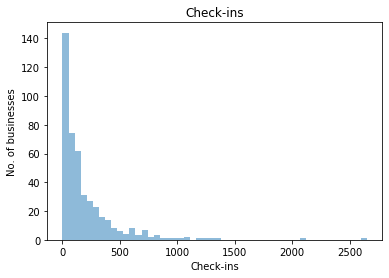

In [43]:
_ = plt.hist(list(user_checkin.num_checkin), bins = 50, alpha = 0.5)
_ = plt.xlabel('Check-ins')
_ = plt.ylabel('No. of businesses')
_ = plt.title('Check-ins')

### Reviews over time

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


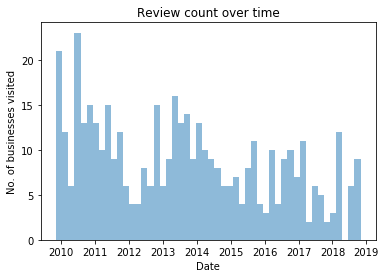

In [44]:
# Plot of user's amount of reviews over time

user = user_business_category.copy()

_ = plt.hist(list(user.datetime), bins = 50, alpha = 0.5)
_ = plt.xlabel('Date')
_ = plt.ylabel('No. of businesses visited')
_ = plt.title('Review count over time')

[Back To The Big Question](#category_user)

### Add a column for the amount of words used by user in the Yelp review

In [45]:
user_clean = user[['review_id', 'user_id', 'business_id', 'text', 'datetime']]
user_clean['review_word_count'] = 0

for x in range(user_clean.shape[0]):
    review_text = user_clean['text'].iloc[x]
    text_count = sum([i.strip(string.punctuation).isalpha() for i in review_text.split()])
    user_clean['review_word_count'].iloc[x] = text_count

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


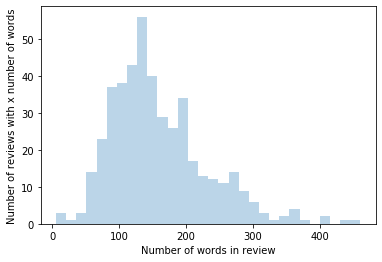

In [46]:
_ = plt.hist(list(user_clean['review_word_count']), bins = 30, alpha = 0.3)
_ = plt.xlabel('Number of words in review')
_ = plt.ylabel('Number of reviews with x number of words')

### Checking the difference in the user's rating of a business versus the posted Yelp rating of a business

In [47]:
business_rating = df_business[['business_id','name','stars', 'review_count', 'attributes']].set_index('business_id')

In [48]:
user_business = user[['user_id', 'review_id', 'business_id', 'datetime', 'stars', 'text']]\
    .join(business_rating, on='business_id', how='left', lsuffix='_user_rating', rsuffix='_bus_rating')

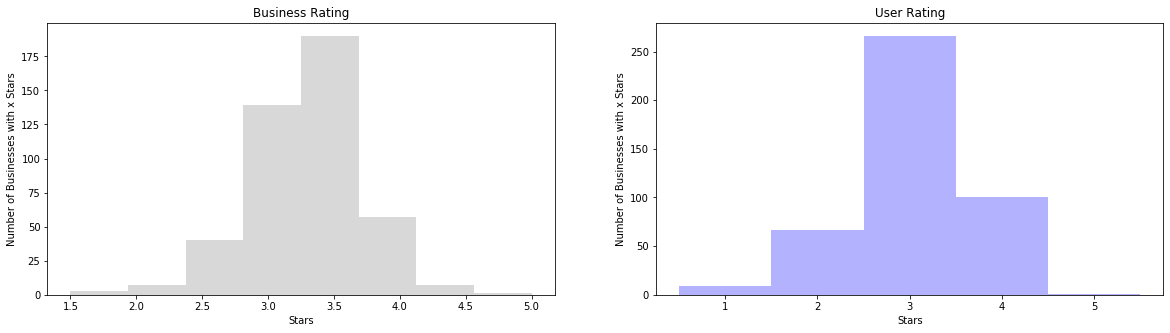

In [49]:
_ = plt.figure(figsize = (20,5))

bins = user_business['stars_bus_rating'].value_counts().shape[0]
_ = plt.subplot(1, 2, 1)
_ = plt.hist(list(user_business['stars_bus_rating']), bins = bins, color = 'gray', alpha = 0.3)
_ = plt.xlabel('Stars')
_ = plt.ylabel('Number of Businesses with x Stars')
_ = plt.title('Business Rating')


bins = user_business['stars_user_rating'].value_counts().shape[0]
_ = plt.subplot(1, 2, 2)
_ = plt.hist(list(user_business['stars_user_rating']), bins=np.arange(bins+1)+0.5, color = 'blue', alpha = 0.3)
_ = plt.xticks([1, 2, 3, 4, 5])
_ = plt.xlabel('Stars')
_ = plt.ylabel('Number of Businesses with x Stars')
_ = plt.title('User Rating')

In [50]:
user_business['rating_diff'] = user_business['stars_user_rating'] - user_business['stars_bus_rating']

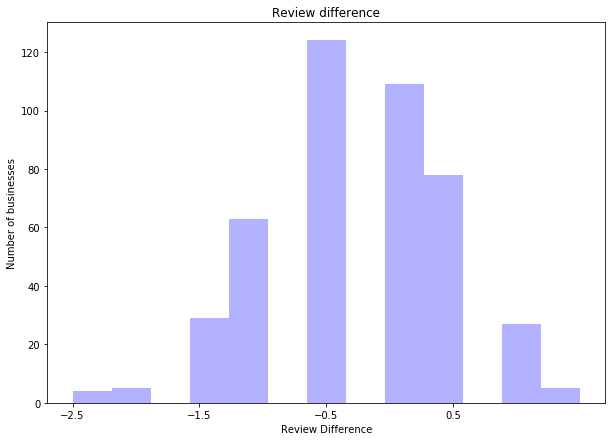

In [51]:
_ = plt.figure(figsize = (10,7))

_ = plt.hist(list(user_business['rating_diff']), bins=13, color = 'blue', alpha = 0.3)
_ = plt.xticks(np.arange(min(list(user_business['rating_diff'])), max(list(user_business['rating_diff']))))
_ = plt.xlabel('Review Difference')
_ = plt.ylabel('Number of businesses')
_ = plt.title('Review difference')

# Splitting the Dataset based on Positive vs Negative ratings

In [52]:
user_pos_rating = user_business.query('rating_diff >= 1 or stars_user_rating >= 4')
user_neg_rating = user_business.query('rating_diff < 1 and stars_user_rating < 4')

## Analysis of amount of words used for positively & negatively rated businesses

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


166.20560747663552


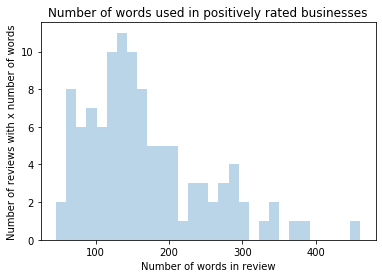

In [53]:
user_pos_review_text = user_pos_rating[['review_id', 'user_id', 'business_id', 'text', 'datetime']]
user_pos_review_text['review_word_count'] = 0

for x in range(user_pos_review_text.shape[0]):
    review_text = user_pos_review_text['text'].iloc[x]
    text_count = sum([i.strip(string.punctuation).isalpha() for i in review_text.split()])
    user_pos_review_text['review_word_count'].iloc[x] = text_count

_ = plt.hist(list(user_pos_review_text['review_word_count']), bins = 30, alpha = 0.3)
_ = plt.xlabel('Number of words in review')
_ = plt.ylabel('Number of reviews with x number of words')
_ = plt.title('Number of words used in positively rated businesses')
print(np.mean(user_pos_review_text['review_word_count']))

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


157.10682492581603


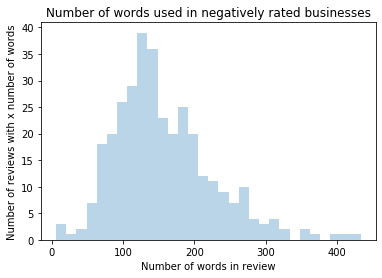

In [54]:
user_neg_review_text = user_neg_rating[['review_id', 'user_id', 'business_id', 'text', 'datetime']]
user_neg_review_text['review_word_count'] = 0

for x in range(user_neg_review_text.shape[0]):
    review_text = user_neg_review_text['text'].iloc[x]
    text_count = sum([i.strip(string.punctuation).isalpha() for i in review_text.split()])
    user_neg_review_text['review_word_count'].iloc[x] = text_count

_ = plt.hist(list(user_neg_review_text['review_word_count']), bins = 30, alpha = 0.3)
_ = plt.xlabel('Number of words in review')
_ = plt.ylabel('Number of reviews with x number of words')
_ = plt.title('Number of words used in negatively rated businesses')
print(np.mean(user_neg_review_text['review_word_count']))

Net Positive Ratings: 
Mean: 3.4299065420560746 
Median: 3.5     
Standard Deviation: 0.5572319695612649 

Net Negative Ratings: 
Mean: 3.258160237388724     
Median: 3.5 
Standard Deviation: 0.46395301661233207


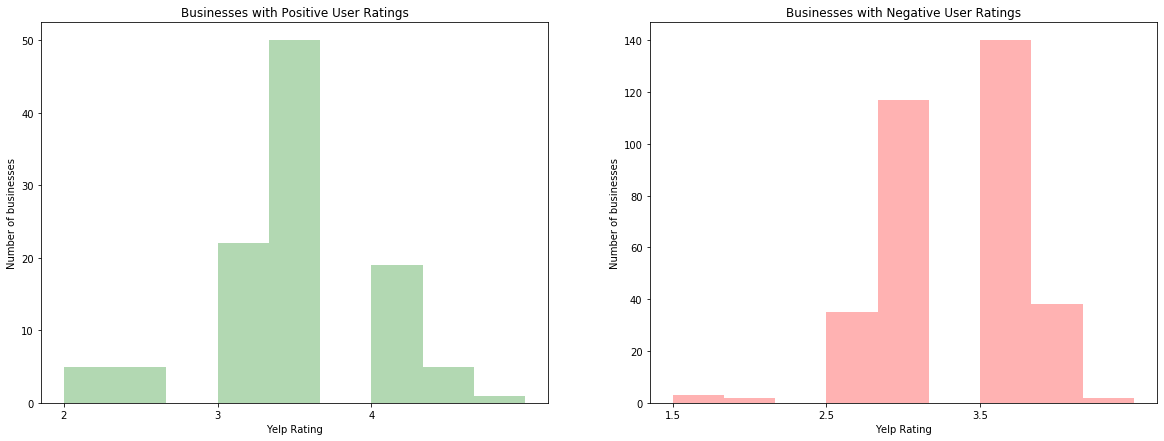

In [55]:
_ = plt.figure(figsize = (20,7))

_ = plt.subplot(1, 2, 1)
field_int = list(user_pos_rating['stars_bus_rating'])
_ = plt.hist(field_int, bins=9, color = 'green', alpha = 0.3)
_ = plt.xticks(np.arange(min(field_int), max(field_int)))
_ = plt.xlabel('Yelp Rating')
_ = plt.ylabel('Number of businesses')
_ = plt.title('Businesses with Positive User Ratings')

_ = plt.subplot(1, 2, 2)
field_int = list(user_neg_rating['stars_bus_rating'])
_ = plt.hist(field_int, bins=9, color = 'red', alpha = 0.3)
_ = plt.xticks(np.arange(min(field_int), max(field_int)))
_ = plt.xlabel('Yelp Rating')
_ = plt.ylabel('Number of businesses')
_ = plt.title('Businesses with Negative User Ratings')

mean_pos_rating = np.mean(user_pos_rating['stars_bus_rating'])
median_pos_rating = np.median(user_pos_rating['stars_bus_rating'])
std_pos_rating = np.std(user_pos_rating['stars_bus_rating'])

mean_neg_rating = np.mean(user_neg_rating['stars_bus_rating'])
median_neg_rating = np.median(user_neg_rating['stars_bus_rating'])
std_neg_rating = np.std(user_neg_rating['stars_bus_rating'])

print(f"Net Positive Ratings: \nMean: {mean_pos_rating} \nMedian: {median_pos_rating} \
    \nStandard Deviation: {std_pos_rating} \n\nNet Negative Ratings: \nMean: {mean_neg_rating} \
    \nMedian: {median_neg_rating} \nStandard Deviation: {std_neg_rating}")


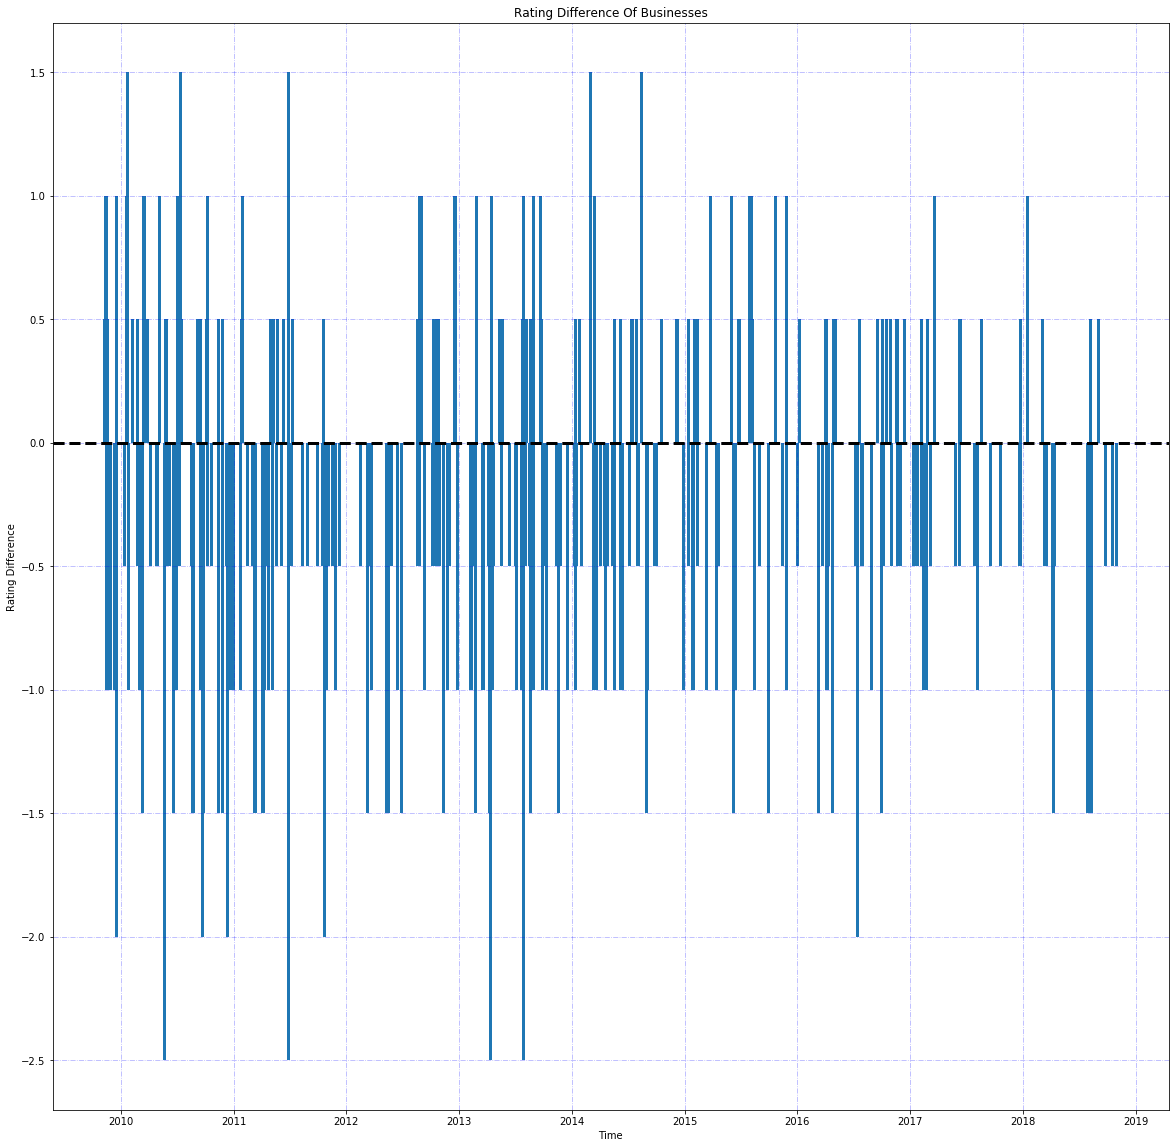

In [56]:
number = user_business.shape[0]
_ = plt.figure(figsize = (20,20))
_ = plt.bar(x = user_business['datetime'].head(number), height = user_business['rating_diff'].head(number),
           width = 10)
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.axhline(0, color = 'k', linestyle = '--', linewidth = 3)
_ = plt.ylabel('Rating Difference')
_ = plt.xlabel('Time')
_ = plt.title('Rating Difference Of Businesses')

In [57]:
user_rating0 = user_business.query("stars_user_rating == 0.0")
user_rating1 = user_business.query("stars_user_rating == 1.0")
user_rating2 = user_business.query("stars_user_rating == 2.0")
user_rating3 = user_business.query("stars_user_rating == 3.0")
user_rating4 = user_business.query("stars_user_rating == 4.0")
user_rating5 = user_business.query("stars_user_rating == 5.0")

business_rating1 = user_business.query("stars_bus_rating <= 1.5")
business_rating2 = user_business.query("stars_bus_rating == 2.0 or stars_bus_rating == 2.5")
business_rating3 = user_business.query("stars_bus_rating == 3.0 or stars_bus_rating == 3.5")
business_rating4 = user_business.query("stars_bus_rating == 4.0 or stars_bus_rating == 4.5")
business_rating5 = user_business.query("stars_bus_rating == 5.0")

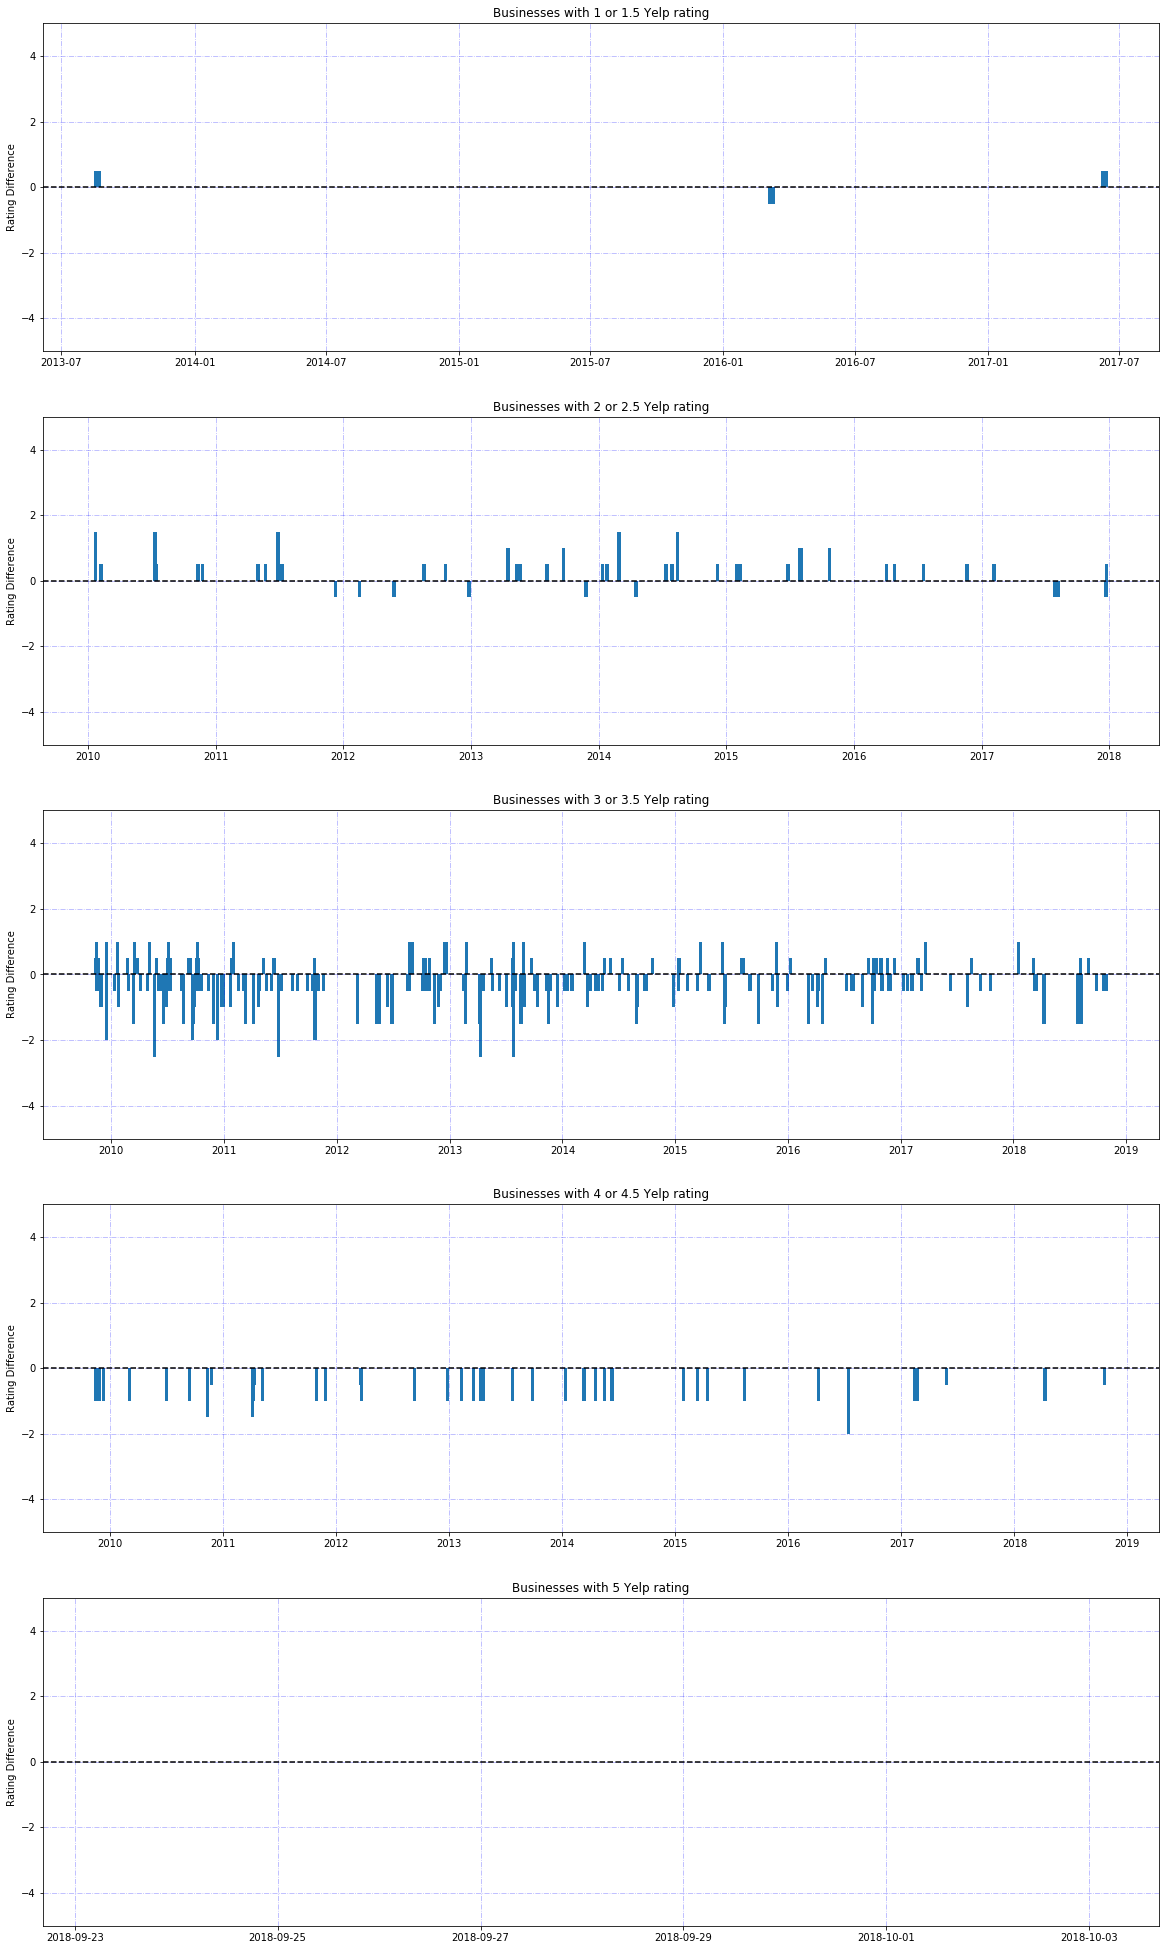

In [58]:
_ = plt.figure(figsize=[20,35])

df_rating_diff = business_rating1

number = df_rating_diff.shape[0]
_ = plt.subplot(5,1,1)
_ = plt.bar(x = df_rating_diff['datetime'].head(number), height = df_rating_diff['rating_diff'].head(number),
           width = 10)
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.ylim(-5,5)
_ = plt.axhline(0, color = 'k', linestyle = '--')
_ = plt.ylabel('Rating Difference')
_ = plt.title('Businesses with 1 or 1.5 Yelp rating')

df_rating_diff = business_rating2

number = df_rating_diff.shape[0]
_ = plt.subplot(5,1,2)
_ = plt.bar(x = df_rating_diff['datetime'].head(number), height = df_rating_diff['rating_diff'].head(number),
           width = 10)
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.ylim(-5,5)
_ = plt.axhline(0, color = 'k', linestyle = '--')
_ = plt.ylabel('Rating Difference')
_ = plt.title('Businesses with 2 or 2.5 Yelp rating')

df_rating_diff = business_rating3

number = df_rating_diff.shape[0]
_ = plt.subplot(5,1,3)
_ = plt.bar(x = df_rating_diff['datetime'].head(number), height = df_rating_diff['rating_diff'].head(number),
           width = 10)
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.ylim(-5,5)
_ = plt.axhline(0, color = 'k', linestyle = '--')
_ = plt.ylabel('Rating Difference')
_ = plt.title('Businesses with 3 or 3.5 Yelp rating')

df_rating_diff = business_rating4

number = df_rating_diff.shape[0]
_ = plt.subplot(5,1,4)
_ = plt.bar(x = df_rating_diff['datetime'].head(number), height = df_rating_diff['rating_diff'].head(number),
           width = 10)
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.ylim(-5,5)
_ = plt.axhline(0, color = 'k', linestyle = '--')
_ = plt.ylabel('Rating Difference')
_ = plt.title('Businesses with 4 or 4.5 Yelp rating')

df_rating_diff = business_rating5

number = df_rating_diff.shape[0]
_ = plt.subplot(5,1,5)
_ = plt.bar(x = df_rating_diff['datetime'].head(number), height = df_rating_diff['rating_diff'].head(number),
           width = 10)
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.ylim(-5,5)
_ = plt.axhline(0, color = 'k', linestyle = '--')
_ = plt.ylabel('Rating Difference')
_ = plt.title('Businesses with 5 Yelp rating')

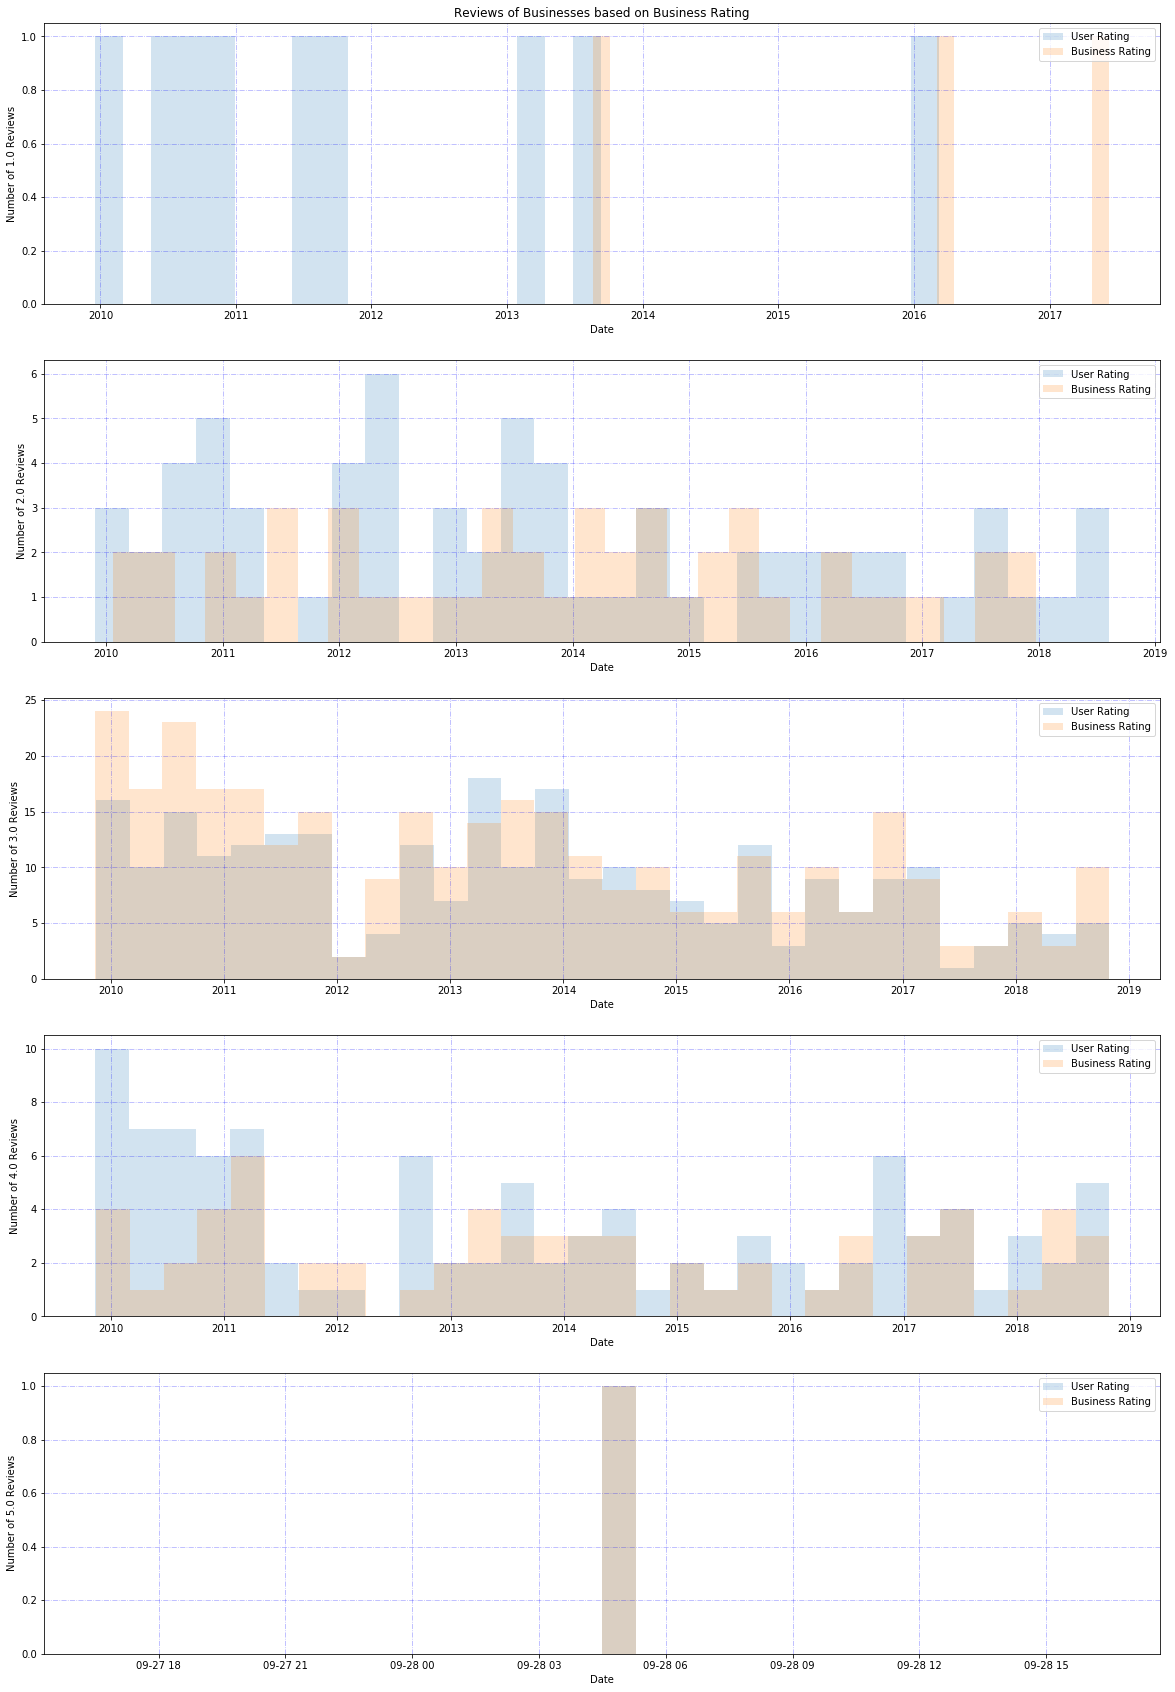

In [59]:
_ = plt.figure(figsize=[20,30])
bins = 30

# Plot of the user's ratings for a business & a business' ratings
_ = plt.subplot(5,1,1)
if user_rating1.shape[0] == 0:
    pass
else:
    _ = plt.hist(list(user_rating1['datetime']), bins = bins, alpha = 0.2, label = 'User Rating')
_ = plt.hist(list(business_rating1['datetime']), bins = bins, alpha = 0.2, label = 'Business Rating')
_ = plt.title('Reviews of Businesses based on Business Rating')
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of 1.0 Reviews')
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.legend()

_ = plt.subplot(5,1,2)
_ = plt.hist(list(user_rating2['datetime']), bins = bins, alpha = 0.2, label = 'User Rating')
_ = plt.hist(list(business_rating2['datetime']), bins = bins, alpha = 0.2, label = 'Business Rating')
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of 2.0 Reviews')
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.legend()

_ = plt.subplot(5,1,3)
_ = plt.hist(list(user_rating3['datetime']), bins = bins, alpha = 0.2, label = 'User Rating')
_ = plt.hist(list(business_rating3['datetime']), bins = bins, alpha = 0.2, label = 'Business Rating')
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of 3.0 Reviews')
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.legend()

_ = plt.subplot(5,1,4)
_ = plt.hist(list(user_rating4['datetime']), bins = bins, alpha = 0.2, label = 'User Rating')
_ = plt.hist(list(business_rating4['datetime']), bins = bins, alpha = 0.2, label = 'Business Rating')
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of 4.0 Reviews')
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.legend()

_ = plt.subplot(5,1,5)
_ = plt.hist(list(user_rating5['datetime']), bins = bins, alpha = 0.2, label = 'User Rating')
_ = plt.hist(list(business_rating5['datetime']), bins = bins, alpha = 0.2, label = 'Business Rating')
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of 5.0 Reviews')
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.legend()

In the above plot for the "User Rating" and the "Business Rating", the plots tell us that this user would say that these businesses in blue should have __ rating. The businesses in orange are the ones that do actually have __ rating.

In [60]:
user_pos_rating_attrib_count = user_pos_rating.copy().reset_index().drop('index', axis = 1)

In [61]:
for x in range(user_pos_rating_attrib_count.shape[0]):
    try:
        user_pos_rating_attrib_count.at[x, 'num_attrib'] = len(str_to_other(user_pos_rating_attrib_count.attributes[x]).keys())
    except:
        user_pos_rating_attrib_count.at[x, 'num_attrib'] = 0

In [62]:
user_neg_rating_attrib_count = user_neg_rating.copy().reset_index().drop('index', axis = 1)

In [63]:
for x in range(user_neg_rating_attrib_count.shape[0]):
    try:
        user_neg_rating_attrib_count.at[x, 'num_attrib'] = len(str_to_other(user_neg_rating_attrib_count.attributes[x]).keys())
    except:
        user_neg_rating_attrib_count.at[x, 'num_attrib'] = 0

[Back To The Big Question](#category_user)

<a id="part_1"></a>

[Back To Top](#back_to_top)

<div class="alert alert-block alert-info">

# Part 1: Number of Attributes Posted
### *Determine if there is a difference in the Yelper's ratings due to number of attributes*

</div>

#### Null Hypothesis: The number of attributes posted on Yelp affects the Yelper's rating of the business
#### Alternative Hypothesis: The number of attributes posted on Yelp does not affect the Yelper's rating of the business

In [64]:
user_pos_rating_attrib_count.head()

,user_id,review_id,business_id,datetime,stars_user_rating,text,name,stars_bus_rating,review_count,attributes,rating_diff,num_attrib
0,CxDOIDnH8gp9KXzpBHJYXw,U1bz3WPLcVdZ-14HBaW7tg,hRbUkwU9awUan32CD-mdHA,2010-03-16 21:26:03,4.0,A good place for dim sum. All the dim sums are...,Golden Court Abalone Restaurant,3.0,72,"{'GoodForKids': 'True', 'RestaurantsPriceRange...",1.0,18.0
1,CxDOIDnH8gp9KXzpBHJYXw,fdf3ZWoWi-DGONRTmvzgCA,QHZw2L6LV1qmExNJbfhIsQ,2013-02-25 04:09:18,4.0,I think a lot of the usual Cafe Cogo's custome...,Skyview Fusion Cuisine,3.0,161,"{'Ambience': ""{'romantic': False, 'intimate': ...",1.0,18.0
2,CxDOIDnH8gp9KXzpBHJYXw,9UGyh60Qhx5pWh8hbVBB7Q,u3wWKIIdTZuAYqa2jHJoxA,2010-05-27 20:40:48,4.0,Konner Chinese Restaurant is located at a bran...,Konner Chinese Restaurant,3.5,21,"{'Ambience': ""{'romantic': False, 'intimate': ...",0.5,14.0
3,CxDOIDnH8gp9KXzpBHJYXw,EQJGh-FdOio8AZQIQGd79w,u3wWKIIdTZuAYqa2jHJoxA,2011-05-09 03:56:48,4.0,I been coming back to Konner Chinese Restauran...,Konner Chinese Restaurant,3.5,21,"{'Ambience': ""{'romantic': False, 'intimate': ...",0.5,14.0
4,CxDOIDnH8gp9KXzpBHJYXw,inlnXE99dFz5H-zi-ZULjw,VFr0wUWq-qwe6nIRjdRYvg,2013-05-16 20:21:11,4.0,3.5 Star rounded up to a 4 Star\n\nStone Cafe ...,Stone Cafe,3.5,9,"{'RestaurantsDelivery': 'False', 'RestaurantsR...",0.5,15.0


In [65]:
user_neg_rating_attrib_count.head()

,user_id,review_id,business_id,datetime,stars_user_rating,text,name,stars_bus_rating,review_count,attributes,rating_diff,num_attrib
0,CxDOIDnH8gp9KXzpBHJYXw,9BJj4e1wCfkbK11mgSi4jA,TvHC_I01Ilvd5_fFi4sqIg,2014-01-17 00:53:31,3.0,Huge Buns! Good Quality!\n\nBrothers Bakery ha...,Brothers Bakery,3.5,17,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...",-0.5,18.0
1,CxDOIDnH8gp9KXzpBHJYXw,x1pG83XFBdcBk8ar36D-hQ,lkM72Y21bjBqUGaW7iL7tQ,2010-10-05 23:14:20,3.0,This review updated is based on dim sum experi...,Very Fair,3.0,83,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...",0.0,17.0
2,CxDOIDnH8gp9KXzpBHJYXw,47povAMFrG2bC1U8IG05nQ,lkM72Y21bjBqUGaW7iL7tQ,2010-01-25 04:08:47,2.0,I am going to rate Very Fair Seafood Restauran...,Very Fair,3.0,83,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...",-1.0,17.0
3,CxDOIDnH8gp9KXzpBHJYXw,TiZrg7mxr4iTdhvFuGJzjg,s0kM86trPEkOKv3quDnoGw,2015-08-07 21:17:18,3.0,Golden Sunrise Kitchen is a typical Hong Kong ...,Golden Sunrise Kitchen,3.0,20,"{'RestaurantsAttire': ""u'casual'"", 'OutdoorSea...",0.0,21.0
4,CxDOIDnH8gp9KXzpBHJYXw,9e6N6HUQBovQw9JL8NY4Vw,j1QfFrTE22PAak7rzD8OoQ,2010-08-23 03:57:46,3.0,Sweet Culture is another one of the Chinese De...,Sweet Culture,3.5,39,"{'OutdoorSeating': 'False', 'NoiseLevel': ""u'q...",-0.5,15.0


The mean and standard deviation of the number of attributes are 16.11 and 3.92, respectively.


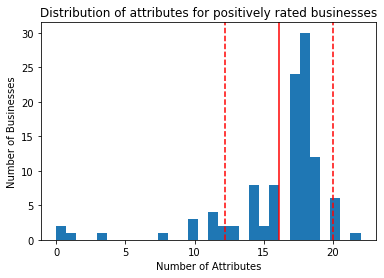

In [66]:
_ = plt.hist(user_pos_rating_attrib_count['num_attrib'], bins = 30)
_ = plt.xlabel('Number of Attributes')
_ = plt.ylabel('Number of Businesses')
_ = plt.title('Distribution of attributes for positively rated businesses')

pos_attributes_mean = np.mean(user_pos_rating_attrib_count['num_attrib'])
pos_attributes_std = np.std(user_pos_rating_attrib_count['num_attrib'])

_ = plt.axvline(pos_attributes_mean, color='r')
_ = plt.axvline(pos_attributes_mean + pos_attributes_std, color='r', linestyle='--')
_ = plt.axvline(pos_attributes_mean - pos_attributes_std, color='r', linestyle='--')

print(f'The mean and standard deviation of the number of attributes are {round(pos_attributes_mean, 2)}\
 and {round(pos_attributes_std, 2)}, respectively.')

The mean and standard deviation of the number of attributes are 15.88 and 4.21, respectively.


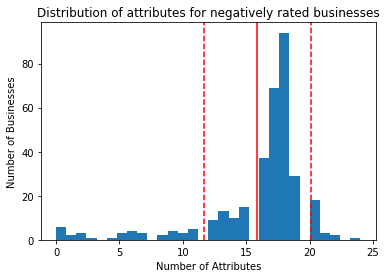

In [67]:
_ = plt.hist(user_neg_rating_attrib_count['num_attrib'], bins = 30)
_ = plt.xlabel('Number of Attributes')
_ = plt.ylabel('Number of Businesses')
_ = plt.title('Distribution of attributes for negatively rated businesses')

neg_attributes_mean = np.mean(user_neg_rating_attrib_count['num_attrib'])
neg_attributes_std = np.std(user_neg_rating_attrib_count['num_attrib'])

_ = plt.axvline(neg_attributes_mean, color='r')
_ = plt.axvline(neg_attributes_mean + neg_attributes_std, color='r', linestyle='--')
_ = plt.axvline(neg_attributes_mean - neg_attributes_std, color='r', linestyle='--')

print(f'The mean and standard deviation of the number of attributes are {round(neg_attributes_mean, 2)}\
 and {round(neg_attributes_std, 2)}, respectively.')

In [68]:
statistic, pvalue = scipy.stats.ttest_ind(user_pos_rating_attrib_count['num_attrib'],\
                                          user_neg_rating_attrib_count['num_attrib'], axis = 0)
(statistic, pvalue)

(0.49488149856107067, 0.6209296741138619)

In [69]:
statistic, pvalue = scipy.stats.ttest_ind(user_pos_rating_attrib_count['num_attrib'],\
                                          user_neg_rating_attrib_count['num_attrib'], axis = 0, equal_var = False)
(statistic, pvalue)

(0.5125051121751241, 0.6088954749960243)

<div class="alert alert-block alert-warning">

# Part 1: Conclusion - Number of Attributes Posted

</div>

### The p-value very high at more than 60%. The null hypothesis - that the number of attributes posted affects a Yelper's rating - does not have to be rejected.

[Back To The Big Question](#category_user)

<a id="part_2"></a>

[Back To Top](#back_to_top)

<div class="alert alert-block alert-info">

# Part 2: Number of Yelp Reviews
### *Determine if there is a difference  in the Yelper's ratings due to number of reviews*

</div>

#### Null Hypothesis: The number of reviews posted on Yelp affects the Yelper's rating of the business
#### Alternative Hypothesis: The number of reviews posted on Yelp does not affect the Yelper's rating of the business

In [70]:
user_pos_rating.head()

,user_id,review_id,business_id,datetime,stars_user_rating,text,name,stars_bus_rating,review_count,attributes,rating_diff
7,CxDOIDnH8gp9KXzpBHJYXw,U1bz3WPLcVdZ-14HBaW7tg,hRbUkwU9awUan32CD-mdHA,2010-03-16 21:26:03,4.0,A good place for dim sum. All the dim sums are...,Golden Court Abalone Restaurant,3.0,72,"{'GoodForKids': 'True', 'RestaurantsPriceRange...",1.0
8,CxDOIDnH8gp9KXzpBHJYXw,fdf3ZWoWi-DGONRTmvzgCA,QHZw2L6LV1qmExNJbfhIsQ,2013-02-25 04:09:18,4.0,I think a lot of the usual Cafe Cogo's custome...,Skyview Fusion Cuisine,3.0,161,"{'Ambience': ""{'romantic': False, 'intimate': ...",1.0
11,CxDOIDnH8gp9KXzpBHJYXw,9UGyh60Qhx5pWh8hbVBB7Q,u3wWKIIdTZuAYqa2jHJoxA,2010-05-27 20:40:48,4.0,Konner Chinese Restaurant is located at a bran...,Konner Chinese Restaurant,3.5,21,"{'Ambience': ""{'romantic': False, 'intimate': ...",0.5
12,CxDOIDnH8gp9KXzpBHJYXw,EQJGh-FdOio8AZQIQGd79w,u3wWKIIdTZuAYqa2jHJoxA,2011-05-09 03:56:48,4.0,I been coming back to Konner Chinese Restauran...,Konner Chinese Restaurant,3.5,21,"{'Ambience': ""{'romantic': False, 'intimate': ...",0.5
18,CxDOIDnH8gp9KXzpBHJYXw,inlnXE99dFz5H-zi-ZULjw,VFr0wUWq-qwe6nIRjdRYvg,2013-05-16 20:21:11,4.0,3.5 Star rounded up to a 4 Star\n\nStone Cafe ...,Stone Cafe,3.5,9,"{'RestaurantsDelivery': 'False', 'RestaurantsR...",0.5


In [71]:
user_neg_rating.head()

,user_id,review_id,business_id,datetime,stars_user_rating,text,name,stars_bus_rating,review_count,attributes,rating_diff
0,CxDOIDnH8gp9KXzpBHJYXw,9BJj4e1wCfkbK11mgSi4jA,TvHC_I01Ilvd5_fFi4sqIg,2014-01-17 00:53:31,3.0,Huge Buns! Good Quality!\n\nBrothers Bakery ha...,Brothers Bakery,3.5,17,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...",-0.5
1,CxDOIDnH8gp9KXzpBHJYXw,x1pG83XFBdcBk8ar36D-hQ,lkM72Y21bjBqUGaW7iL7tQ,2010-10-05 23:14:20,3.0,This review updated is based on dim sum experi...,Very Fair,3.0,83,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...",0.0
2,CxDOIDnH8gp9KXzpBHJYXw,47povAMFrG2bC1U8IG05nQ,lkM72Y21bjBqUGaW7iL7tQ,2010-01-25 04:08:47,2.0,I am going to rate Very Fair Seafood Restauran...,Very Fair,3.0,83,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...",-1.0
3,CxDOIDnH8gp9KXzpBHJYXw,TiZrg7mxr4iTdhvFuGJzjg,s0kM86trPEkOKv3quDnoGw,2015-08-07 21:17:18,3.0,Golden Sunrise Kitchen is a typical Hong Kong ...,Golden Sunrise Kitchen,3.0,20,"{'RestaurantsAttire': ""u'casual'"", 'OutdoorSea...",0.0
4,CxDOIDnH8gp9KXzpBHJYXw,9e6N6HUQBovQw9JL8NY4Vw,j1QfFrTE22PAak7rzD8OoQ,2010-08-23 03:57:46,3.0,Sweet Culture is another one of the Chinese De...,Sweet Culture,3.5,39,"{'OutdoorSeating': 'False', 'NoiseLevel': ""u'q...",-0.5


The mean and standard deviation of the number of reviews are 77.32 and 80.03, respectively.


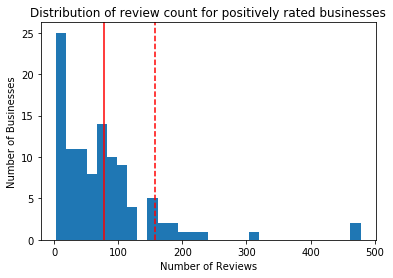

In [72]:
_ = plt.hist(user_pos_rating['review_count'], bins = 30)
_ = plt.xlabel('Number of Reviews')
_ = plt.ylabel('Number of Businesses')
_ = plt.title('Distribution of review count for positively rated businesses')

pos_review_count_mean = np.mean(user_pos_rating['review_count'])
pos_review_count_std = np.std(user_pos_rating['review_count'])

_ = plt.axvline(pos_review_count_mean, color='r')
_ = plt.axvline(pos_review_count_mean + pos_review_count_std, color='r', linestyle='--')

print(f'The mean and standard deviation of the number of reviews are {round(pos_review_count_mean, 2)}\
 and {round(pos_review_count_std, 2)}, respectively.')

The mean and standard deviation of the number of reviews are 71.45 and 94.18, respectively.


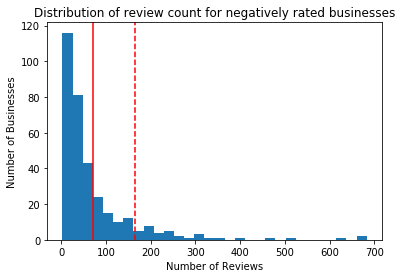

In [73]:
_ = plt.hist(user_neg_rating['review_count'], bins = 30)
_ = plt.xlabel('Number of Reviews')
_ = plt.ylabel('Number of Businesses')
_ = plt.title('Distribution of review count for negatively rated businesses')

neg_review_count_mean = np.mean(user_neg_rating['review_count'])
neg_review_count_std = np.std(user_neg_rating['review_count'])

_ = plt.axvline(neg_review_count_mean, color='r')
_ = plt.axvline(neg_review_count_mean + neg_review_count_std, color='r', linestyle='--')

print(f'The mean and standard deviation of the number of reviews are {round(neg_review_count_mean, 2)}\
 and {round(neg_review_count_std, 2)}, respectively.')

In [74]:
statistic, pvalue = scipy.stats.ttest_ind(user_pos_rating['review_count'],\
                                          user_neg_rating['review_count'], axis = 0)
(statistic, pvalue)

(0.5795804385224137, 0.5624928735729935)

In [75]:
statistic, pvalue = scipy.stats.ttest_ind(user_pos_rating['review_count'],\
                                          user_neg_rating['review_count'], axis = 0, equal_var = False)
(statistic, pvalue)

(0.6293082645803565, 0.5298431250630689)

<div class="alert alert-block alert-warning">

# Part 2: Conclusion - Number of Yelp Reviews

</div>

### The p-value very high at more than 50%. The null hypothesis - that the number of Yelp reviews online affects a Yelper's rating - does not have to be rejected.

[Back To The Big Question](#category_user)

<a id="part_3"></a>

[Back To Top](#back_to_top)

<div class="alert alert-block alert-info">

# Part 3: Yelp Business Rating

### *Determine if there is a difference in the Yelper's ratings due to a business' posted rating on Yelp*

</div>

#### Null Hypothesis: The star rating posted on Yelp affects the Yelper's rating of the business
#### Alternative Hypothesis: The star rating posted on Yelp does not affect the Yelper's rating of the business

In [76]:
user_pos_rating.head()

,user_id,review_id,business_id,datetime,stars_user_rating,text,name,stars_bus_rating,review_count,attributes,rating_diff
7,CxDOIDnH8gp9KXzpBHJYXw,U1bz3WPLcVdZ-14HBaW7tg,hRbUkwU9awUan32CD-mdHA,2010-03-16 21:26:03,4.0,A good place for dim sum. All the dim sums are...,Golden Court Abalone Restaurant,3.0,72,"{'GoodForKids': 'True', 'RestaurantsPriceRange...",1.0
8,CxDOIDnH8gp9KXzpBHJYXw,fdf3ZWoWi-DGONRTmvzgCA,QHZw2L6LV1qmExNJbfhIsQ,2013-02-25 04:09:18,4.0,I think a lot of the usual Cafe Cogo's custome...,Skyview Fusion Cuisine,3.0,161,"{'Ambience': ""{'romantic': False, 'intimate': ...",1.0
11,CxDOIDnH8gp9KXzpBHJYXw,9UGyh60Qhx5pWh8hbVBB7Q,u3wWKIIdTZuAYqa2jHJoxA,2010-05-27 20:40:48,4.0,Konner Chinese Restaurant is located at a bran...,Konner Chinese Restaurant,3.5,21,"{'Ambience': ""{'romantic': False, 'intimate': ...",0.5
12,CxDOIDnH8gp9KXzpBHJYXw,EQJGh-FdOio8AZQIQGd79w,u3wWKIIdTZuAYqa2jHJoxA,2011-05-09 03:56:48,4.0,I been coming back to Konner Chinese Restauran...,Konner Chinese Restaurant,3.5,21,"{'Ambience': ""{'romantic': False, 'intimate': ...",0.5
18,CxDOIDnH8gp9KXzpBHJYXw,inlnXE99dFz5H-zi-ZULjw,VFr0wUWq-qwe6nIRjdRYvg,2013-05-16 20:21:11,4.0,3.5 Star rounded up to a 4 Star\n\nStone Cafe ...,Stone Cafe,3.5,9,"{'RestaurantsDelivery': 'False', 'RestaurantsR...",0.5


In [77]:
user_neg_rating.head()

,user_id,review_id,business_id,datetime,stars_user_rating,text,name,stars_bus_rating,review_count,attributes,rating_diff
0,CxDOIDnH8gp9KXzpBHJYXw,9BJj4e1wCfkbK11mgSi4jA,TvHC_I01Ilvd5_fFi4sqIg,2014-01-17 00:53:31,3.0,Huge Buns! Good Quality!\n\nBrothers Bakery ha...,Brothers Bakery,3.5,17,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...",-0.5
1,CxDOIDnH8gp9KXzpBHJYXw,x1pG83XFBdcBk8ar36D-hQ,lkM72Y21bjBqUGaW7iL7tQ,2010-10-05 23:14:20,3.0,This review updated is based on dim sum experi...,Very Fair,3.0,83,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...",0.0
2,CxDOIDnH8gp9KXzpBHJYXw,47povAMFrG2bC1U8IG05nQ,lkM72Y21bjBqUGaW7iL7tQ,2010-01-25 04:08:47,2.0,I am going to rate Very Fair Seafood Restauran...,Very Fair,3.0,83,"{'NoiseLevel': ""u'loud'"", 'RestaurantsGoodForG...",-1.0
3,CxDOIDnH8gp9KXzpBHJYXw,TiZrg7mxr4iTdhvFuGJzjg,s0kM86trPEkOKv3quDnoGw,2015-08-07 21:17:18,3.0,Golden Sunrise Kitchen is a typical Hong Kong ...,Golden Sunrise Kitchen,3.0,20,"{'RestaurantsAttire': ""u'casual'"", 'OutdoorSea...",0.0
4,CxDOIDnH8gp9KXzpBHJYXw,9e6N6HUQBovQw9JL8NY4Vw,j1QfFrTE22PAak7rzD8OoQ,2010-08-23 03:57:46,3.0,Sweet Culture is another one of the Chinese De...,Sweet Culture,3.5,39,"{'OutdoorSeating': 'False', 'NoiseLevel': ""u'q...",-0.5


The mean and standard deviation of the number of reviews are 3.43 and 0.56, respectively.


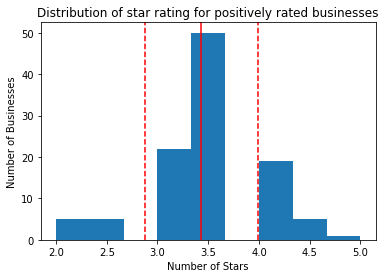

In [78]:
_ = plt.hist(user_pos_rating['stars_bus_rating'], bins = 9)
_ = plt.xlabel('Number of Stars')
_ = plt.ylabel('Number of Businesses')
_ = plt.title('Distribution of star rating for positively rated businesses')

pos_star_rating_mean = np.mean(user_pos_rating['stars_bus_rating'])
pos_star_rating_std = np.std(user_pos_rating['stars_bus_rating'])

_ = plt.axvline(pos_star_rating_mean, color='r')
_ = plt.axvline(pos_star_rating_mean + pos_star_rating_std, color='r', linestyle='--')
_ = plt.axvline(pos_star_rating_mean - pos_star_rating_std, color='r', linestyle='--')

print(f'The mean and standard deviation of the number of reviews are {round(pos_star_rating_mean, 2)}\
 and {round(pos_star_rating_std, 2)}, respectively.')

The mean and standard deviation of the number of reviews are 3.26 and 0.46, respectively.


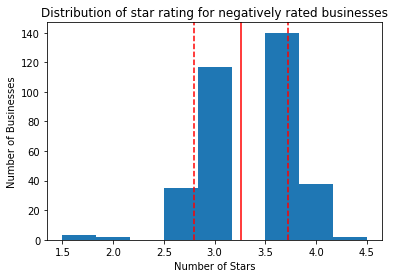

In [79]:
_ = plt.hist(user_neg_rating['stars_bus_rating'], bins = 9)
_ = plt.xlabel('Number of Stars')
_ = plt.ylabel('Number of Businesses')
_ = plt.title('Distribution of star rating for negatively rated businesses')

neg_star_rating_mean = np.mean(user_neg_rating['stars_bus_rating'])
neg_star_rating_std = np.std(user_neg_rating['stars_bus_rating'])

_ = plt.axvline(neg_star_rating_mean, color='r')
_ = plt.axvline(neg_star_rating_mean + neg_star_rating_std, color='r', linestyle='--')
_ = plt.axvline(neg_star_rating_mean - neg_star_rating_std, color='r', linestyle='--')

print(f'The mean and standard deviation of the number of reviews are {round(neg_star_rating_mean, 2)}\
 and {round(neg_star_rating_std, 2)}, respectively.')

In [80]:
statistic, pvalue = scipy.stats.ttest_ind(user_pos_rating['stars_bus_rating'],\
                                          user_neg_rating['stars_bus_rating'], axis = 0)
(statistic, pvalue)

(3.1640564323980733, 0.0016632498679625917)

In [81]:
statistic, pvalue = scipy.stats.ttest_ind(user_pos_rating['stars_bus_rating'],\
                                          user_neg_rating['stars_bus_rating'], axis = 0, equal_var = False)
(statistic, pvalue)

(2.87446128375271, 0.004615752978564084)

<div class="alert alert-block alert-warning">

# Part 3: Conclusion - Yelp Business Rating

</div>

### The p-value is less than 0.5%. The null hypothesis - that the business' posted Yelp rating affects a Yelper's rating - can be rejected.

[Back To The Big Question](#category_user)

<a id="part_4"></a>

[Back To Top](#back_to_top)

<div class="alert alert-block alert-info">

# Part 4: Quality of Posted Photos
### *Determine if there is a difference in the Yelper's ratings due to the quality of the business' photos*

</div>

#### Null Hypothesis: The quality of the photos posted on the business' Yelp page affects the Yelper's rating of the business
#### Alternative Hypothesis: The  quality of the photos posted on the business' Yelp page does not affect the Yelper's rating of the business

In [113]:
business_photos = pd.DataFrame(user_pos_rating.reset_index()['business_id'])
num_photos_bus = business_photos.shape[0]

available_photos = pd.DataFrame()

In [114]:
for x in range(int(round(num_photos_bus/5,0))):
    if df_photo[df_photo[['photo_id', 'business_id', 'label']]['business_id']==\
                business_photos['business_id'][x]].empty == False:
        temp_df = df_photo[df_photo[['photo_id', 'business_id', 'label']]\
                           ['business_id']==business_photos['business_id'][x]]
        available_photos = available_photos.append(temp_df)

available_photos = available_photos.reset_index()
num_photos = available_photos.shape[0]

available_photos['image_score'] = ''

for i in range(num_photos):
    photo_id = available_photos['photo_id'][i]
    image = plt.imread('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_photos/photos/' +
                       photo_id + '.jpg')
    gray_image = skimage.color.rgb2gray(image)

    mscn_coefficients = calculate_mscn_coefficients(gray_image, 7, 7/6)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)

    brisque_features = calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)

    downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
    downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

    brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

    image_score = calculate_image_quality_score(brisque_features)
    available_photos['image_score'][i] = image_score
    
pos_available_photos = available_photos.copy()

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of photos available: 188


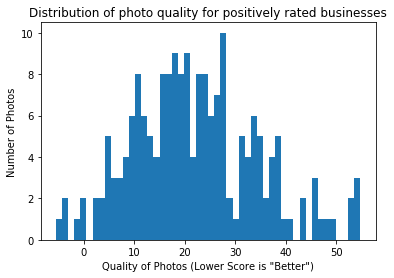

In [115]:
_ = plt.hist(pos_available_photos.image_score, bins = 50)
_ = plt.xlabel('Quality of Photos (Lower Score is "Better")')
_ = plt.ylabel('Number of Photos')
_ = plt.title('Distribution of photo quality for positively rated businesses')
print(f'Number of photos available: {num_photos}')

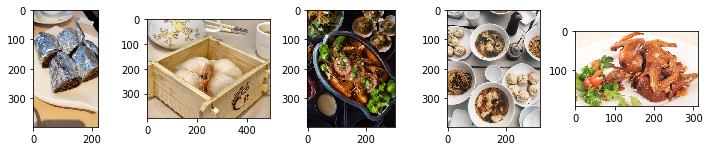

In [116]:
top_amount = 5
top_images = pos_available_photos.sort_values(by = 'image_score', ascending = True).head(top_amount).reset_index()

height = 2*top_amount
plt.figure(figsize = (10, height))
for x in range(top_amount):
    photo_id = top_images['photo_id'][x]
    image = plt.imread('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_photos/photos/' +
                       photo_id + '.jpg')
    plt.subplot(top_amount, 5, x+1)
    skimage.io.imshow(image)

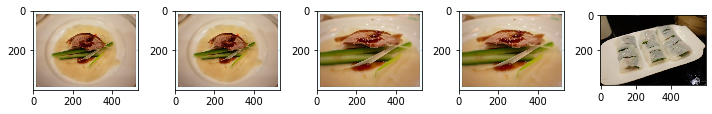

In [117]:
bottom_images = pos_available_photos.sort_values(by = 'image_score', ascending = True).tail(top_amount).reset_index()

height = 2*top_amount
plt.figure(figsize = (10, height))
for x in range(top_amount):
    photo_id = bottom_images['photo_id'][x]
    image = plt.imread('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_photos/photos/' +
                       photo_id + '.jpg')
    plt.subplot(top_amount, 5, x+1)
    skimage.io.imshow(image)

In [118]:
business_photos = pd.DataFrame(user_neg_rating.reset_index()['business_id'])
num_photos_bus = business_photos.shape[0]

available_photos = pd.DataFrame()

In [119]:
for x in range(int(round(num_photos_bus/5,0))):
    if df_photo[df_photo[['photo_id', 'business_id', 'label']]['business_id']==\
                business_photos['business_id'][x]].empty == False:
        temp_df = df_photo[df_photo[['photo_id', 'business_id', 'label']]\
                           ['business_id']==business_photos['business_id'][x]]
        available_photos = available_photos.append(temp_df)

available_photos = available_photos.reset_index()
num_photos = available_photos.shape[0]

available_photos['image_score'] = ''

for i in range(num_photos):
    photo_id = available_photos['photo_id'][i]
    image = plt.imread('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_photos/photos/' +
                       photo_id + '.jpg')
    gray_image = skimage.color.rgb2gray(image)

    mscn_coefficients = calculate_mscn_coefficients(gray_image, 7, 7/6)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)

    brisque_features = calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)

    downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
    downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

    brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

    image_score = calculate_image_quality_score(brisque_features)
    available_photos['image_score'][i] = image_score

neg_available_photos = available_photos.copy()

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of photos available: 420


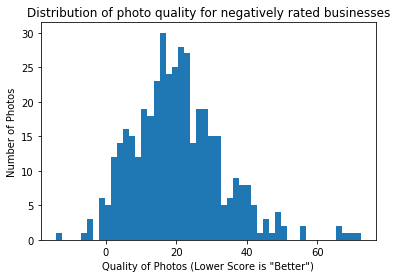

In [120]:
_ = plt.hist(neg_available_photos.image_score, bins = 50)
_ = plt.xlabel('Quality of Photos (Lower Score is "Better")')
_ = plt.ylabel('Number of Photos')
_ = plt.title('Distribution of photo quality for negatively rated businesses')
print(f'Number of photos available: {num_photos}')

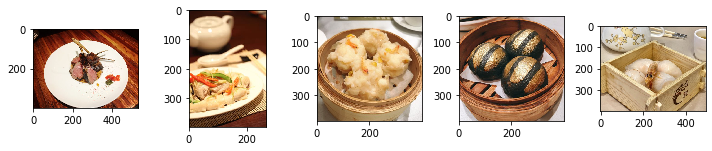

In [121]:
top_amount = 5
top_images = neg_available_photos.sort_values(by = 'image_score', ascending = True).head(top_amount).reset_index()

height = 2*top_amount
plt.figure(figsize = (10, height))
for x in range(top_amount):
    photo_id = top_images['photo_id'][x]
    image = plt.imread('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_photos/photos/' +
                       photo_id + '.jpg')
    plt.subplot(top_amount, 5, x+1)
    skimage.io.imshow(image)

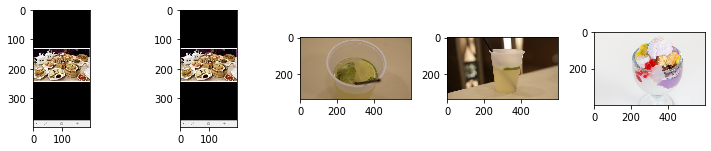

In [122]:
bottom_images = neg_available_photos.sort_values(by = 'image_score', ascending = True).tail(top_amount).reset_index()

height = 2*top_amount
plt.figure(figsize = (10, height))
for x in range(top_amount):
    photo_id = bottom_images['photo_id'][x]
    image = plt.imread('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_photos/photos/' +
                       photo_id + '.jpg')
    plt.subplot(top_amount, 5, x+1)
    skimage.io.imshow(image)

### Let's check to see if the photo quality affects whether a user will go to a business or not...

In [123]:
pos_available_photos.head()

,index,Unnamed: 0,caption,photo_id,business_id,label,image_score
0,5506,5506,outside view from parking lot,FDWaBJUSfIDKv8Z7IBgQUA,hRbUkwU9awUan32CD-mdHA,outside,23.7087
1,5507,5507,inside view,MkjhnHRoL6-GOE66qBWY3w,hRbUkwU9awUan32CD-mdHA,inside,9.29248
2,5508,5508,steamed beef dumplings,2-BzMHXjs3230Ebb7YrCLQ,hRbUkwU9awUan32CD-mdHA,food,15.2643
3,56916,56916,baby veggies steamed dumplings,Skr2BkI_1jrfz_V_OHYmpw,hRbUkwU9awUan32CD-mdHA,food,27.9999
4,95922,95922,NaN,GfSSmHn0Pwgk4ShXIjjC3w,hRbUkwU9awUan32CD-mdHA,outside,26.8725


In [124]:
neg_available_photos.head()

,index,Unnamed: 0,caption,photo_id,business_id,label,image_score
0,110335,110335,NaN,OIAivOE2Rf52v5McFsBBug,TvHC_I01Ilvd5_fFi4sqIg,food,12.5249
1,110336,110336,NaN,yl60H1LFPM2_8rQz9ayCvg,TvHC_I01Ilvd5_fFi4sqIg,food,32.6311
2,4289,4289,NaN,ddqwGAPsDyDxqQ3jAHZOvg,lkM72Y21bjBqUGaW7iL7tQ,inside,23.0388
3,32262,32262,NaN,5jmyR9Kvlx3-2ZMMXd1o1w,lkM72Y21bjBqUGaW7iL7tQ,inside,21.514
4,176443,176443,NaN,cFIMrLAIIXPW34EM0k8L9A,lkM72Y21bjBqUGaW7iL7tQ,food,65.5958


The mean and standard deviation of the photo ratings are 22.04 and 12.39, respectively.


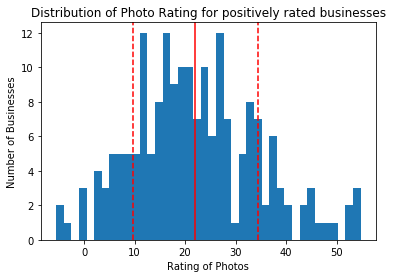

In [125]:
_ = plt.hist(pos_available_photos['image_score'], bins = 40)
_ = plt.xlabel('Rating of Photos')
_ = plt.ylabel('Number of Businesses')
_ = plt.title('Distribution of Photo Rating for positively rated businesses')

pos_image_rating_mean = np.mean(pos_available_photos['image_score'])
pos_image_rating_std = np.std(pos_available_photos['image_score'])

_ = plt.axvline(pos_image_rating_mean, color='r')
_ = plt.axvline(pos_image_rating_mean + pos_image_rating_std, color='r', linestyle='--')
_ = plt.axvline(pos_image_rating_mean - pos_image_rating_std, color='r', linestyle='--')

print(f'The mean and standard deviation of the photo ratings are {round(pos_image_rating_mean, 2)}\
 and {round(pos_image_rating_std, 2)}, respectively.')

The mean and standard deviation of the photo ratings are 20.53 and 12.74, respectively.


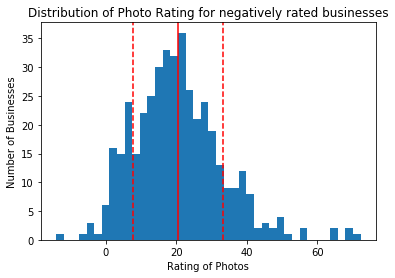

In [126]:
x, y, _ = plt.hist(neg_available_photos['image_score'], bins = 40)
_ = plt.xlabel('Rating of Photos')
_ = plt.ylabel('Number of Businesses')
_ = plt.title('Distribution of Photo Rating for negatively rated businesses')

neg_image_rating_mean = np.mean(neg_available_photos['image_score'])
neg_image_rating_std = np.std(neg_available_photos['image_score'])

_ = plt.axvline(neg_image_rating_mean, color='r')
_ = plt.axvline(neg_image_rating_mean + neg_image_rating_std, color='r', linestyle='--')
_ = plt.axvline(neg_image_rating_mean - neg_image_rating_std, color='r', linestyle='--')

print(f'The mean and standard deviation of the photo ratings are {round(neg_image_rating_mean, 2)}\
 and {round(neg_image_rating_std, 2)}, respectively.')

In [127]:
statistic, pvalue = scipy.stats.ttest_ind(pos_available_photos['image_score'],\
                                          neg_available_photos['image_score'], axis = 0)
(statistic, pvalue)

(1.3556677593688333, 0.17570989549959123)

In [128]:
statistic, pvalue = scipy.stats.ttest_ind(pos_available_photos['image_score'],\
                                          neg_available_photos['image_score'], axis = 0, equal_var = False)
(statistic, pvalue)

(1.3692220828032697, 0.17176405484030133)

<div class="alert alert-block alert-warning">

# Part 4: Conclusion - Quality of Posted Photos

</div>

### The p-value is somewhat high at about 17%. The null hypothesis - that the quality of the business photos affects a Yelper's rating - does not have to be rejected; however, it should be noted that based on the quality rating, the businesses that were negatively rated by the Yelper has a mean score that is better than that of businesses that were positively rated. This result needs to be further analyzed to see if the quality rating test is valid and trustworthy.

[Back To The Big Question](#category_user)

[Back To Top](#back_to_top)